In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
# Lemmatization 

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim 
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet

import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim import matutils, models


In [185]:
# Reading new data from 2013 to 2020
data = pd.read_csv("Data/business-licences.csv", sep = ";")
data = data.query("City == 'Vancouver'")

/Users/eitharelbasheer/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


> will update FOLDERYEAR to be in the correct format before moving on

In [186]:
data["FOLDERYEAR"] = data.FOLDERYEAR.apply(lambda x: 1900 + x if x > 90 else 2000 + x)

In [12]:
data.to_csv("Data/data.csv")

## EDA

In [ ]:
train.shape[0] - train.LicenceRSN.nunique()

> Some duplicate RSNs. (Noted in the documentaion)

In [ ]:
train.groupby(by = "FOLDERYEAR").LicenceNumber.nunique()

> I believe that year 96 is not useful and can be dropped. 

In [13]:
data = data.query("FOLDERYEAR != 1996.0")

In [ ]:
data.isna().any()

> Many missing values. Luckily, non in LicenceRSN.

In [ ]:
train.Status.unique()

In [ ]:
train.Status.value_counts()

> Will only consider the Issued licences.

In [ ]:
train.IssuedDate

> Issue date is not consistent.

In [ ]:
train.ExpiredDate

In [14]:
data = data.query("Status == 'Issued'")
data.IssuedDate = data.IssuedDate.str.extract(r'(\d{4}\-\d{2}\-\d{2}).*', expand = False)

### A look at the Business Type Distribution in Downtown Area

In [15]:
Downtown = data.query("LocalArea == 'Downtown'")

In [19]:
Downtown = Downtown.groupby(by = ["FOLDERYEAR", "BusinessType"]).count().reset_index()[["FOLDERYEAR", "BusinessType", "LicenceRSN"]]

In [22]:
alt.renderers.enable('mimetype')
alt.Chart(Downtown).mark_line().encode(
    x='FOLDERYEAR:N',
    y="LicenceRSN:Q",
    color = "BusinessType"
).properties(width = 600, height = 400, title = "Business Type Distribution in Vancouver Downtown Area")

<img src="Images/downtown.png" height="1000" width="1000">

> We got a taste of the change of the number and type of businesses in downtown Vancouver. 

> Seems for most of the Businesses the number was pretty stable. 

## Analysis

> NLP peprocessing to clean the BusinessType cloumn is needed.

In [199]:
# punc = list(string.punctuation)
# stop_words = list(set(stopwords.words('english')))
# punctuation = string.punctuation
# stop_words += list(punctuation)
# stop_words.extend(['``','’', '`','br','"',"”", "''", "'s"]) 

# def nlp(text):
    
#     """
#     Performs NLP preprocessing including tokenization, stop-words removal and Lemmatiztion.
    
#     Parameters
#     -----------------
#     text: input text (str)
    
#     Returns
#     ------------------
#     a list containing the words of the preprocessed text
    
#     """
#     for p in punc:
#         text = text.replace(p, "")
#     preprocessed = []    
#     tokenized = word_tokenize(text)
#     for token in tokenized:
#         token = token.lower()
#         if token not in stop_words:
#             preprocessed.append(token)
#     lemmatizer= WordNetLemmatizer()
    
#     lemmatized = []
#     for word in preprocessed:
#         lemmatized.append(lemmatizer.lemmatize(word,'n'))
#     return " ".join(lemmatized) 

In [196]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
stop_words = list(set(stopwords.words('english')))
stop_words += list(punctuation)
stop_words.extend(['``','’', '`','br','"',"”", "''", "'s"]) 

In [200]:
def preprocess_nlp(text, 
               min_token_len = 2, 
               irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE'], stop = stop_words ): 
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text 
    and return a preprocessed string. 
    
    Parameters
    -------------
    text : (str) 
        text to be preprocessed
    min_token_len : (int) 
        min_token_length required
    irrelevant_pos : (list) 
        a list of irrelevant pos tags
    
    Returns
    -------------
    (str) the preprocessed text
    """
    #YOUR CODE HERE

    doc = nlp(text)
    output = ""
    for d in doc:
        if len(d.text) > min_token_len and d.pos_ not in irrelevant_pos:
            if d.text not in stop:
                output = output+" "+d.lemma_
    output = output[1:]
    return output

In [ ]:
from pandarallel import pandarallel

pandarallel.initialize()
data['BusinessType'] = data['BusinessType'].parallel_apply(preprocess_nlp)

### Building LDA Topic Model for Bussiness Types

In [10]:
corpus = [doc.split() for doc in data['BusinessType'].tolist()]
dictionary = corpora.Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

In [267]:
model_lda = models.LdaModel(corpus=doc_term_matrix, 
                      id2word=dictionary, 
                      num_topics=15, passes = 10)

model_lda.print_topics()

[(0,
  '0.667*"studio" + 0.180*"artist" + 0.147*"livework" + 0.000*"dwelling" + 0.000*"onefamily" + 0.000*"suite" + 0.000*"secondary" + 0.000*"permanent" + 0.000*"class" + 0.000*"restaurant"'),
 (1,
  '0.888*"store" + 0.098*"pet" + 0.000*"dwelling" + 0.000*"onefamily" + 0.000*"suite" + 0.000*"permanent" + 0.000*"secondary" + 0.000*"adult" + 0.000*"restaurant" + 0.000*"class"'),
 (2,
  '0.891*"auto" + 0.105*"detailing" + 0.000*"dwelling" + 0.000*"onefamily" + 0.000*"secondary" + 0.000*"permanent" + 0.000*"suite" + 0.000*"restaurant" + 0.000*"class" + 0.000*"1"'),
 (3,
  '0.404*"dealer" + 0.291*"retail" + 0.099*"food" + 0.086*"wholesale" + 0.048*"manufacturer" + 0.024*"estate" + 0.024*"real" + 0.009*"secondhand" + 0.006*"anc" + 0.004*"grocery"'),
 (4,
  '0.214*"apartment" + 0.214*"lease" + 0.214*"house99" + 0.214*"year" + 0.001*"dwelling" + 0.001*"class" + 0.001*"restaurant" + 0.001*"secondary" + 0.001*"suite" + 0.001*"permanent"'),
 (5,
  '0.340*"auto" + 0.313*"parking" + 0.310*"lotpark

In [3]:
# Save model to disk.
from gensim.test.utils import datapath
temp_file = datapath("model_lda")
model_lda.save(temp_file)

In [4]:
lda = LdaModel.load(temp_file)

In [7]:
topic_labels = {0:'Car Services', 1: 'Short term Rental', 2:'Restaurants', 3: 'Dealer and Retailer', 4: 'Parkade', 5: 'School' , 6: 'Office', 7: 'Rental and Booking Agency', 8: 'Shoe Repair', 9: "Dancing Club",
               10: "Hotel and Rental Agency", 11: 'Beauty Salon', 12: 'Contractor', 13: 'Rental Management services', 14: 'Freelancer'}

In [11]:
vec = doc_term_matrix

topics = lda[vec]
result = list()


In [12]:
topic_match = [topic_labels[max(element,key=lambda item:item[1])[0]] for element in topics]

In [13]:
data["Business_type_pp"] = pd.Series(topic_match)

In [14]:
data.to_csv("Data/data.csv")

### Altair plots

In [15]:
dataset = pd.read_csv("Data/data.csv").dropna(subset=['Geom', 'LocalArea'])[["FOLDERYEAR", "LicenceRSN", "LocalArea", "Business_type_pp", "Geom"]]

/Users/eitharelbasheer/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
import ast

In [17]:
dataset["X"] = dataset.Geom.apply(lambda x: ast.literal_eval(x)['coordinates'][0])
dataset["Y"] = dataset.Geom.apply(lambda x: ast.literal_eval(x)['coordinates'][1])

In [20]:
dataset = dataset.drop(columns = "Geom")

In [21]:
dataset.to_csv("Data/dataset.csv")

In [22]:
dataset

,FOLDERYEAR,LicenceRSN,LocalArea,Business_type_pp,X,Y
0,2013,1772137,Marpole,Contractor,-123.132095,49.208765
1,2013,1772139,Kitsilano,Contractor,-123.153109,49.267533
2,2013,1772140,Fairview,Rental and Booking Agency,-123.123692,49.258919
3,2013,1772141,Kitsilano,Rental and Booking Agency,-123.156734,49.271458
4,2013,1772149,Mount Pleasant,Contractor,-123.113264,49.260075
...,...,...,...,...,...,...
362610,2020,3504762,Mount Pleasant,Parkade,-123.112466,49.262867
362611,2020,3504765,Fairview,Parkade,-123.145040,49.265207
362612,2020,3504771,Mount Pleasant,Parkade,-123.101607,49.270424
362613,2020,3504774,Sunset,Parkade,-123.077583,49.225555


> Will only consider Beauty Salon for the introductory visualization

In [221]:
dataset_subset = dataset.query("Business_type_pp == 'Beauty Salon'").drop(columns = ["Geom", "Business_type_pp"])

In [230]:
dataset.query("Business_type_pp == 'Beauty Salon' or X == 100")

,FOLDERYEAR,LicenceRSN,LocalArea,Business_type_pp,Geom,X,Y
0,2013,1772137,Marpole,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1320954...",-123.132095,49.208765
1,2013,1772139,Kitsilano,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1531087...",-123.153109,49.267533
2,2013,1772140,Fairview,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1236924...",-123.123692,49.258919
3,2013,1772141,Kitsilano,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1567342...",-123.156734,49.271458
4,2013,1772149,Mount Pleasant,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1132642...",-123.113264,49.260075
...,...,...,...,...,...,...,...
257129,2019,3262265,Downtown,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1219798...",-123.121980,49.288849
258272,2018,3033852,Sunset,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.0981087...",-123.098109,49.206440
258273,2018,2997668,Kitsilano,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.1568636...",-123.156864,49.265381
258274,2018,3033857,Strathcona,Beauty Salon,"{""type"": ""Point"", ""coordinates"": [-123.0777738...",-123.077774,49.281002


In [13]:
url = "https://maps.vancouver.ca/server/rest/services/Hosted/NeighbourhoodBoundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

In [174]:
import requests

# Vancouver Map Json file
r = requests.get(url)
file = r.json()
background_data = alt.Data(values=file['features'])

# Vancouver Background
background = alt.Chart(background_data).mark_geoshape(
    fill='lightgray',
    stroke='white'
    ).encode(
    ).properties(
    width=500,
    height=300
)


In [225]:
dataset_subset_grouped = dataset_subset.groupby(by = "LocalArea").aggregate({"LicenceRSN": 'count', "X": "mean", "Y": "mean"}).reset_index()

In [53]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [226]:
points = alt.Chart(dataset_subset_grouped).mark_circle().encode(
    longitude='X:Q',
    latitude='Y:Q',
    size=alt.Size('LicenceRSN:Q', title='Number of Beauty Salons'),
    color=alt.value('steelblue')
).properties(
    title='Number of Beauty Salons in Vancouver per Neighbourhood'
)

In [178]:
(background + points).save('Images/chart.html')

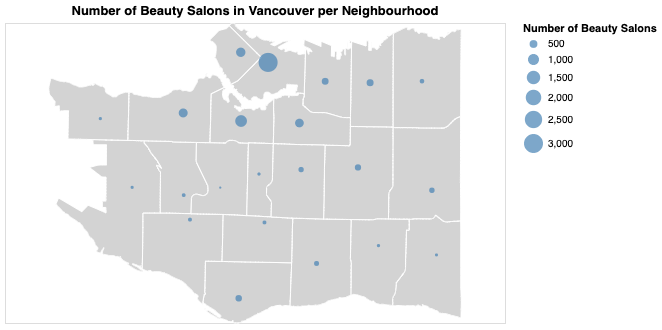

In [227]:
background + points